<a href="https://colab.research.google.com/github/Offliners/Deep-Learning-note/blob/main/Chapter_3_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**調用模組**

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

**模組輸入層的維度設定**

In [9]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)  # 圖片的shape
z_dim = 100  # 指定隨機雜訊向量的長度

**生成器**

In [10]:
def build_generator(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(128, input_dim=z_dim))  # 建立全連接層(隱藏層)
  model.add(LeakyReLU(alpha=0.01))  # 指定Leaky ReLU為隱藏層的激活函數
  model.add(Dense(28 * 28 * 1, activation='tanh'))  # 建立輸出層，指定tanh為激活函數
  model.add(Reshape(img_shape))  # 重塑生成器的輸出shape，使其符合圖片維度

  return model

**鑑別器**

In [11]:
def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))  # 將輸入圖片展平，拉成一維
  model.add(Dense(128))  # 建立全連接層(隱藏層)
  model.add(LeakyReLU(alpha=0.01))  # 激活函數設為Leaky ReLU
  model.add(Dense(1, activation='sigmoid'))  # 建立輸出層，並指定sigmoid為激活函數

  return model

**建立GAN**

In [17]:
def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  return model

**編譯GAN**

In [30]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

discriminator.trainable = False  # 將鑑別器的參數鎖住以便訓練生成器

generator = build_generator(img_shape, z_dim)  # 建立生成器

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())  # 將鎖住的鑑別器與生成器組合成GAN模型，然後編譯，此模型是用來訓練生成器

**撰寫用來訓練鑑別器集生成器的函式**

In [31]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  (X_train, _), (_, _) = mnist.load_data()  # 輸入MNIST資料集
                                            # _ 為不會用到的變數，通常以底線作為變數名稱命名
  X_train = X_train / 127.5 - 1.0  # 將灰階像素值從範圍[0, 255]轉換到[-1, 1]
  X_train = np.expand_dims(X_train, axis=3)
  real = np.ones((batch_size, 1))  # 將真圖片的標籤設為1
  fake = np.zeros((batch_size, 1))  # 將假圖片的標籤設為0

  for iteration in range(iterations):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]  # 隨機挑選一批真圖片

    z = np.random.normal(0, 1, (batch_size, 100))  # 直接從標準常態分佈(平均值為0，標準差為1)中取樣
    gen_imgs = generator.predict(z)  # 生成一批假圖片

    # 訓練鑑別器
    d_loss_real = discriminator.train_on_batch(imgs, real)  # 真圖片(imgs)的標籤設為1
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)  # 假圖片(gen_imgs)的標籤設為0
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)  # 紀錄平均損失值與準確率

    # 以下開始訓練生成器
    z = np.random.normal(0, 1, (batch_size, 100))  # 生成一批標準常態分佈的雜訊向量
    g_loss = gan.train_on_batch(z, real)  # 訓練GAN內的生成器，並將標籤設為真

    # 每隔一定迭代次數就紀錄損失與準確率，訓練結束後便能繪出變化圖
    if (iteration + 1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))  # 在螢幕顯示訓練過程
      sample_images(generator)  # 生成圖片並顯示出來

**生成圖片並顯示出來**

In [32]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))  # 取出一組隨機雜訊
  gen_imgs = generator.predict(z)  # 用這組隨機雜訊生成圖片，值在[-1, 1]之間
  gen_imgs = 0.5 * gen_imgs + 0.5  # 將像素值範圍轉換至[0, 1]

  # 設定使用4 * 4的子圖表來顯示16張圖片
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4, 4),
                          sharey=True,
                          sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')  # 將圖片輸出至子圖表
      axs[i, j].axis('off')
      cnt += 1

**開始訓練模型**

1000 [D loss: 0.060816, acc: 98.05%] [G loss: 4.156793]
2000 [D loss: 0.081447, acc: 97.27%] [G loss: 6.465864]
3000 [D loss: 0.114226, acc: 94.53%] [G loss: 5.517824]
4000 [D loss: 0.218537, acc: 92.19%] [G loss: 4.418267]
5000 [D loss: 0.127649, acc: 95.70%] [G loss: 6.318264]
6000 [D loss: 0.369896, acc: 84.77%] [G loss: 4.902224]
7000 [D loss: 0.594954, acc: 78.91%] [G loss: 3.868079]
8000 [D loss: 0.213373, acc: 89.45%] [G loss: 4.067378]
9000 [D loss: 0.426452, acc: 81.64%] [G loss: 2.672716]
10000 [D loss: 0.330458, acc: 86.33%] [G loss: 3.374146]
11000 [D loss: 0.394111, acc: 82.81%] [G loss: 2.929474]
12000 [D loss: 0.399354, acc: 80.47%] [G loss: 2.551377]
13000 [D loss: 0.346580, acc: 84.77%] [G loss: 4.039961]
14000 [D loss: 0.274903, acc: 85.94%] [G loss: 3.072424]
15000 [D loss: 0.390085, acc: 86.72%] [G loss: 2.865738]
16000 [D loss: 0.367835, acc: 82.03%] [G loss: 3.165020]
17000 [D loss: 0.395834, acc: 80.47%] [G loss: 2.565648]
18000 [D loss: 0.324529, acc: 84.38%] [G

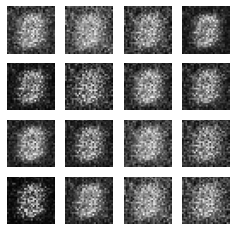

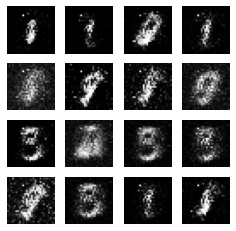

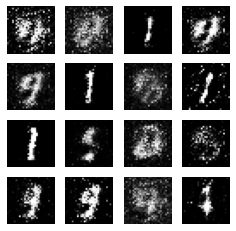

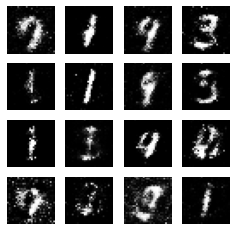

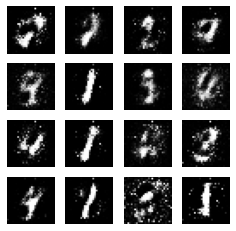

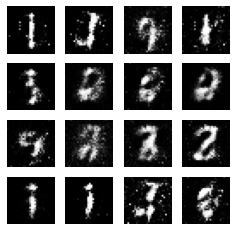

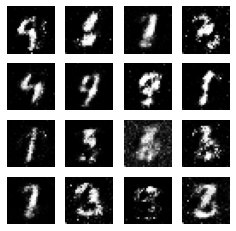

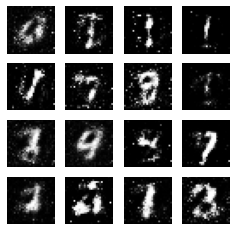

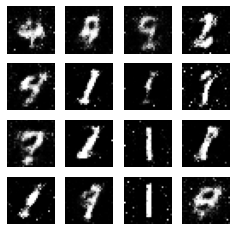

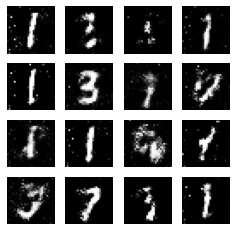

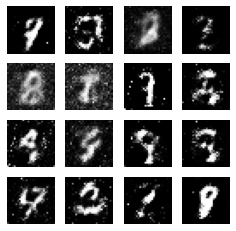

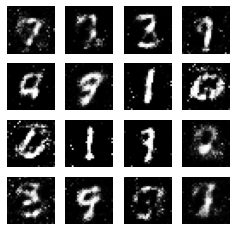

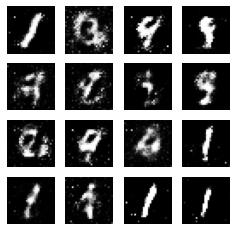

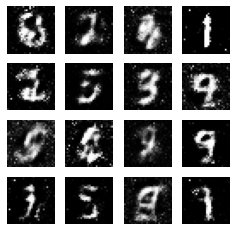

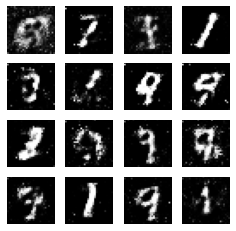

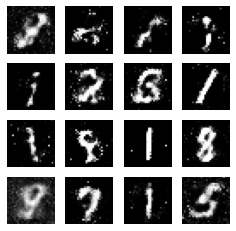

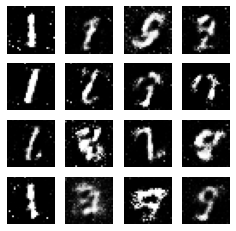

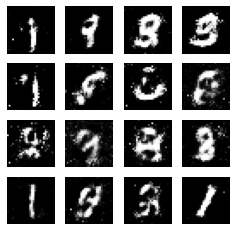

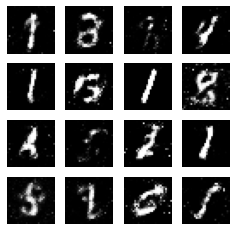

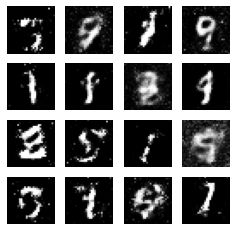

In [33]:
# 設定超參數
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)  # 用指定的迭代次數訓練GAN

**繪製生成器與鑑別器的損失圖**

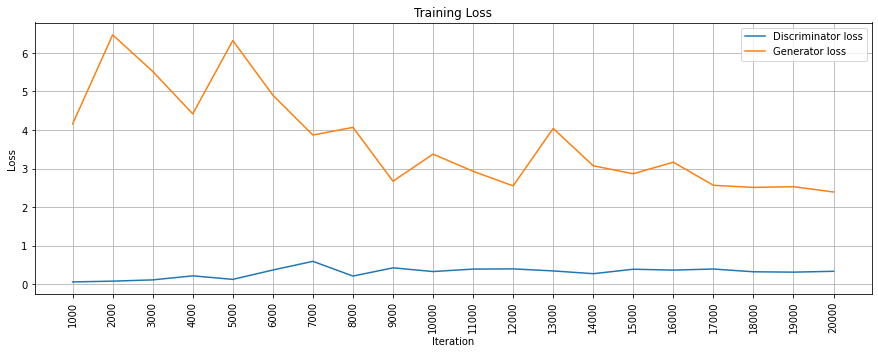

In [34]:

losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.legend()

**繪製鑑別器的準確率圖**

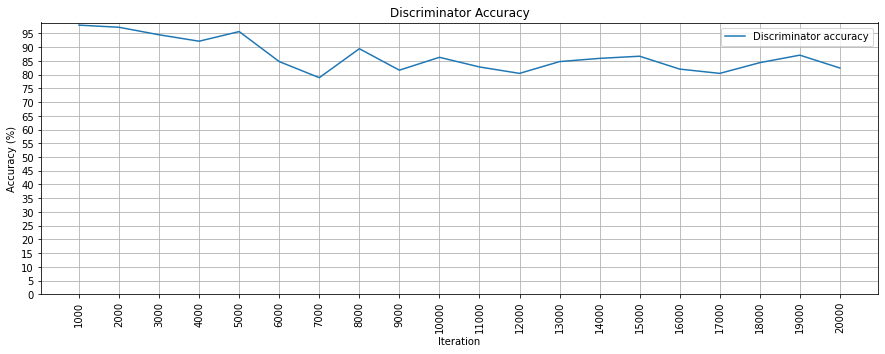

In [35]:
accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))
plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.legend()